<a href="https://colab.research.google.com/github/ele9996/Heart-failure-clinical-records-analysis/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Heart failure data analysis

The goal of the project is to try to predict if a patient with heart failure is likely to survive or not and if there are some driving factors that may lead to heart failure.


##Import useful libraries


In [348]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import random as rand
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import svm
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score
from numpy import mean

#np.random.seed(123)

#Dataset visualization and data exploration


In the following code snippet a visualization of the data is provided
We have both categorical variable (0,1) and numerical (all numbers)

In [349]:
#Dataset import and graphical visualization
df = pd.read_csv('https://raw.githubusercontent.com/ele9996/Heart-failure-clinical-records-analysis/master/heart_failure_clinical_records_dataset.csv')
df


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


##Null entries check
The dataset description says that there are no null enries, let's check

##Correlation study
I check the correlation between attributes in order to try to eliminate one of the two having high correlation between each other

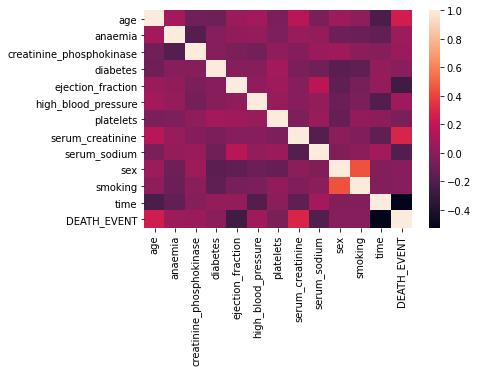

In [350]:
#I calculate correlation and print the correlation matrix
corr = df.corr()
sns.heatmap(corr)
#I notice that that there are no attibutes that are highly correlated one with another so selecting features by imposing a threshold on the correlation seems not to be a good idea


##Data preparation

In [351]:
features = ['age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction','high_blood_pressure','platelets','serum_creatinine','serum_sodium','sex','smoking','time']
numerical_features=[features[0],features[2],features[4],features[6],features[7],features[8],features[11]]
categorical_features=[features[1],features[3],features[5],features[9],features[10]]

#Taking the features and placing in an array
x = df.loc[:, features].values
x_numerical=df.loc[:,numerical_features].values
x_categorical=df.loc[:,categorical_features].values

#Separating the target
y = df.loc[:,['DEATH_EVENT']].values#



x_Df = pd.DataFrame(data = x, columns = features)
x_numerical_Df = pd.DataFrame(data = x_numerical, columns = numerical_features)
x_categorical_Df = pd.DataFrame(data = x_categorical, columns = categorical_features)
y_df=pd.DataFrame(data = y, columns = ['DEATH_EVENT'])





#Features distribution visulization

###Numerical features

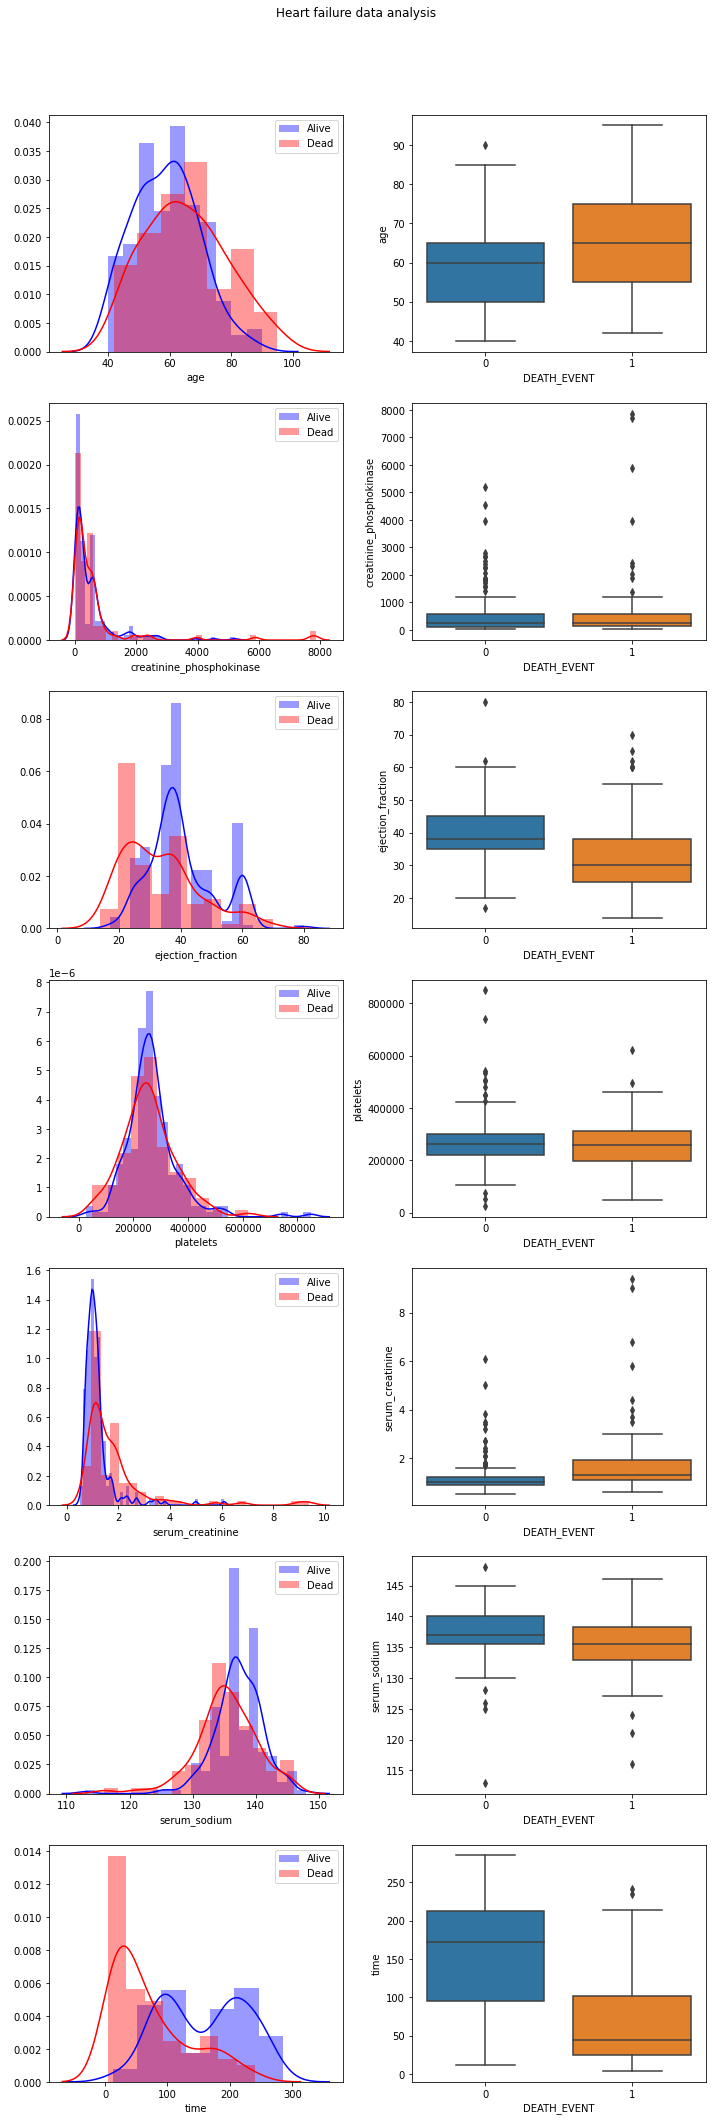

In [352]:
#Visualizing the selected features

fig = plt.figure(figsize = (10, 50))
j = 0
for i in x_numerical_Df.columns:
    plt.subplot(12, 2, j+1)
    j += 1
    
    sns.distplot(x_numerical_Df[i][df['DEATH_EVENT']==0], color='b', label = 'Alive')
    sns.distplot(x_numerical_Df[i][df['DEATH_EVENT']==1], color='r', label = 'Dead')
    plt.legend(loc='best')
    plt.legend(loc='best')
    plt.subplot(12, 2, j+1)
    j += 1
    sns.boxplot(x='DEATH_EVENT', y=x_numerical_Df[i], data=df)

fig.suptitle('Heart failure data analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

###Categorical features

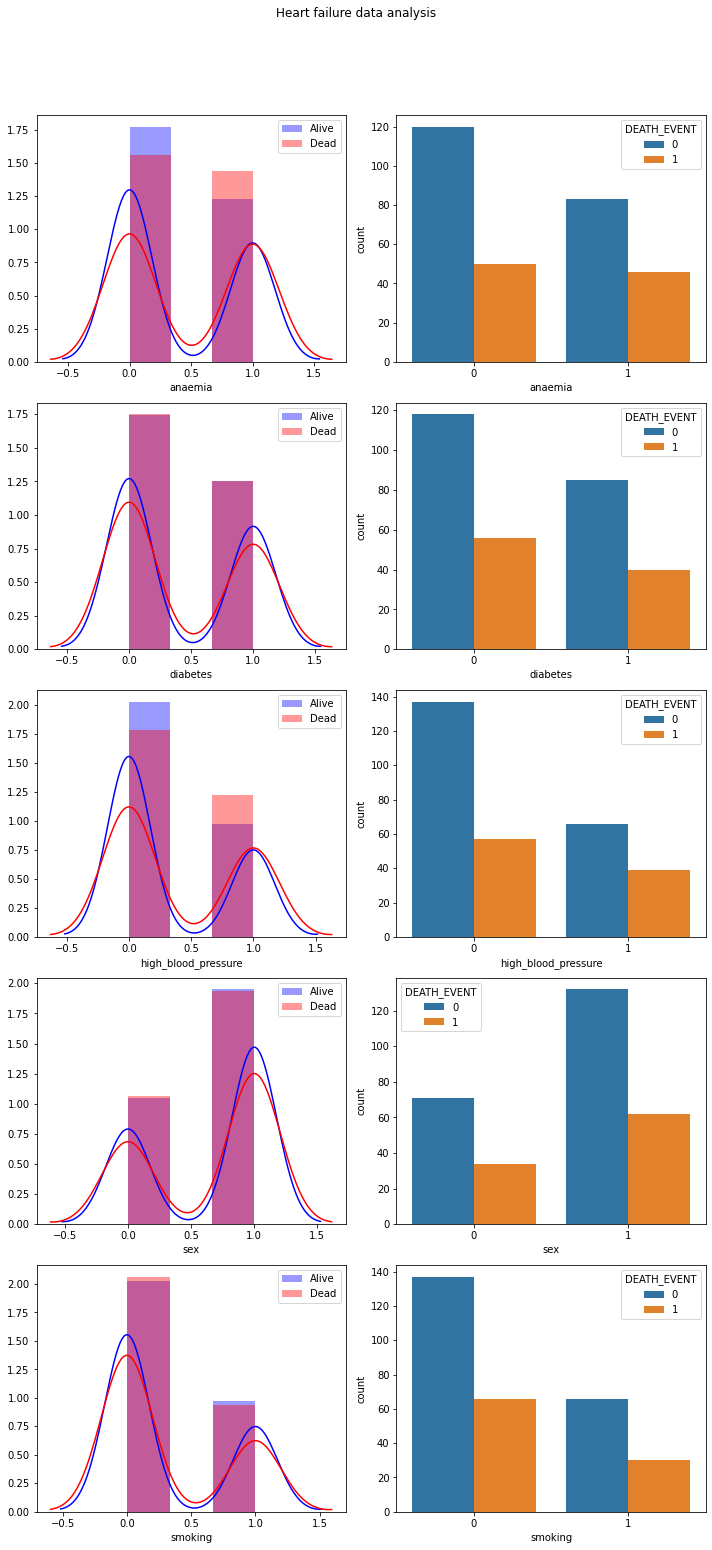

In [353]:
fig = plt.figure(figsize = (10, 50))
j = 0
for i in x_categorical_Df.columns:
    plt.subplot(12, 2, j+1)
    j += 1
    
    sns.distplot(x_categorical_Df[i][df['DEATH_EVENT']==0], color='b', label = 'Alive')
    sns.distplot(x_categorical_Df[i][df['DEATH_EVENT']==1], color='r', label = 'Dead')
    plt.legend(loc='best')
    plt.legend(loc='best')
    plt.subplot(12, 2, j+1)
    j += 1
    sns.countplot(x = x_categorical_Df[i], hue = 'DEATH_EVENT', data = df)

fig.suptitle('Heart failure data analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

#Verify if label distribution is balanced

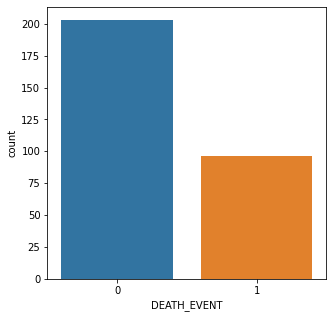

In [354]:
fig = plt.figure(figsize = (5, 5))
sns.countplot(x = 'DEATH_EVENT', data = df)
#inserire grafico a torta

#Data standardization

In [355]:
# Standardizing the features (total, numerical and categorical)
x = StandardScaler().fit_transform(x)

totalDf = pd.concat([x_Df, y_df], axis = 1)

totalDf


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0.0,582.0,0.0,20.0,1.0,265000.00,1.9,130.0,1.0,0.0,4.0,1
1,55.0,0.0,7861.0,0.0,38.0,0.0,263358.03,1.1,136.0,1.0,0.0,6.0,1
2,65.0,0.0,146.0,0.0,20.0,0.0,162000.00,1.3,129.0,1.0,1.0,7.0,1
3,50.0,1.0,111.0,0.0,20.0,0.0,210000.00,1.9,137.0,1.0,0.0,7.0,1
4,65.0,1.0,160.0,1.0,20.0,0.0,327000.00,2.7,116.0,0.0,0.0,8.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0.0,61.0,1.0,38.0,1.0,155000.00,1.1,143.0,1.0,1.0,270.0,0
295,55.0,0.0,1820.0,0.0,38.0,0.0,270000.00,1.2,139.0,0.0,0.0,271.0,0
296,45.0,0.0,2060.0,1.0,60.0,0.0,742000.00,0.8,138.0,0.0,0.0,278.0,0
297,45.0,0.0,2413.0,0.0,38.0,0.0,140000.00,1.4,140.0,1.0,1.0,280.0,0


#Dimesionality Reduction: PCA

Since the dimensionality of the data is quite high and this can decrease the performances in terms of execution time I try to use PCA in order to reduce the number of features.

PCA is affected by scale so features in the data should be standardized in order to assure the best performances.

Standardization means scale the features into unit scale (mean=0, variance=1)


,1,2,3,4,5,6,7,8,9,DEATH_EVENT
0,0.877055,2.287104,1.033230,1.478227,-0.260820,-0.981816,-0.941060,0.556276,-0.932200,1
1,1.863753,-1.552894,0.719821,4.005022,4.273811,-2.832425,2.867899,-0.549446,0.142364,1
2,2.526429,1.369821,1.285596,-0.066119,-0.615287,-0.383891,-0.388868,-0.010873,-0.462690,1
3,0.579566,1.143232,0.631174,-0.920275,-0.374237,-1.221908,1.505988,0.978413,0.258351,1
4,-0.960485,2.639384,4.430958,0.292052,-0.927699,1.024387,0.790721,0.438838,-0.573906,1
...,...,...,...,...,...,...,...,...,...,...
294,0.826097,-1.122232,-0.933378,-0.317703,-0.898043,-0.198186,-1.618193,-1.169096,0.791048,0
295,-0.533627,-2.065782,0.124613,-0.128905,1.648876,-0.352587,-0.330382,1.061233,-0.733559,0
296,-2.415521,-3.837399,-0.298087,2.605030,0.219251,3.014214,1.104456,1.044882,-0.549255,0
297,2.227187,-2.394490,-0.247883,-0.509188,1.379395,-0.662605,-0.141473,0.340837,0.987998,0


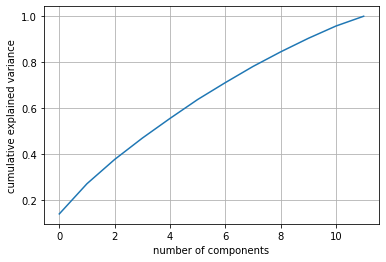

In [356]:
#to choose the correct number of components I plot cumulative explained variance ratio as a function of the number of components.

pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

#probabilmente sceglierò il 9 perchè copre quasi tutta la  varianza (circa 90%)

pca = PCA(n_components=9)
principalComponents = pca.fit_transform(x)#
feature_names=['1', '2','3','4','5','6','7','8','9']
principalDf = pd.DataFrame(data = principalComponents, columns = feature_names)

finalDf = pd.concat([principalDf, df[['DEATH_EVENT']]], axis = 1)

principalComponents
finalDf


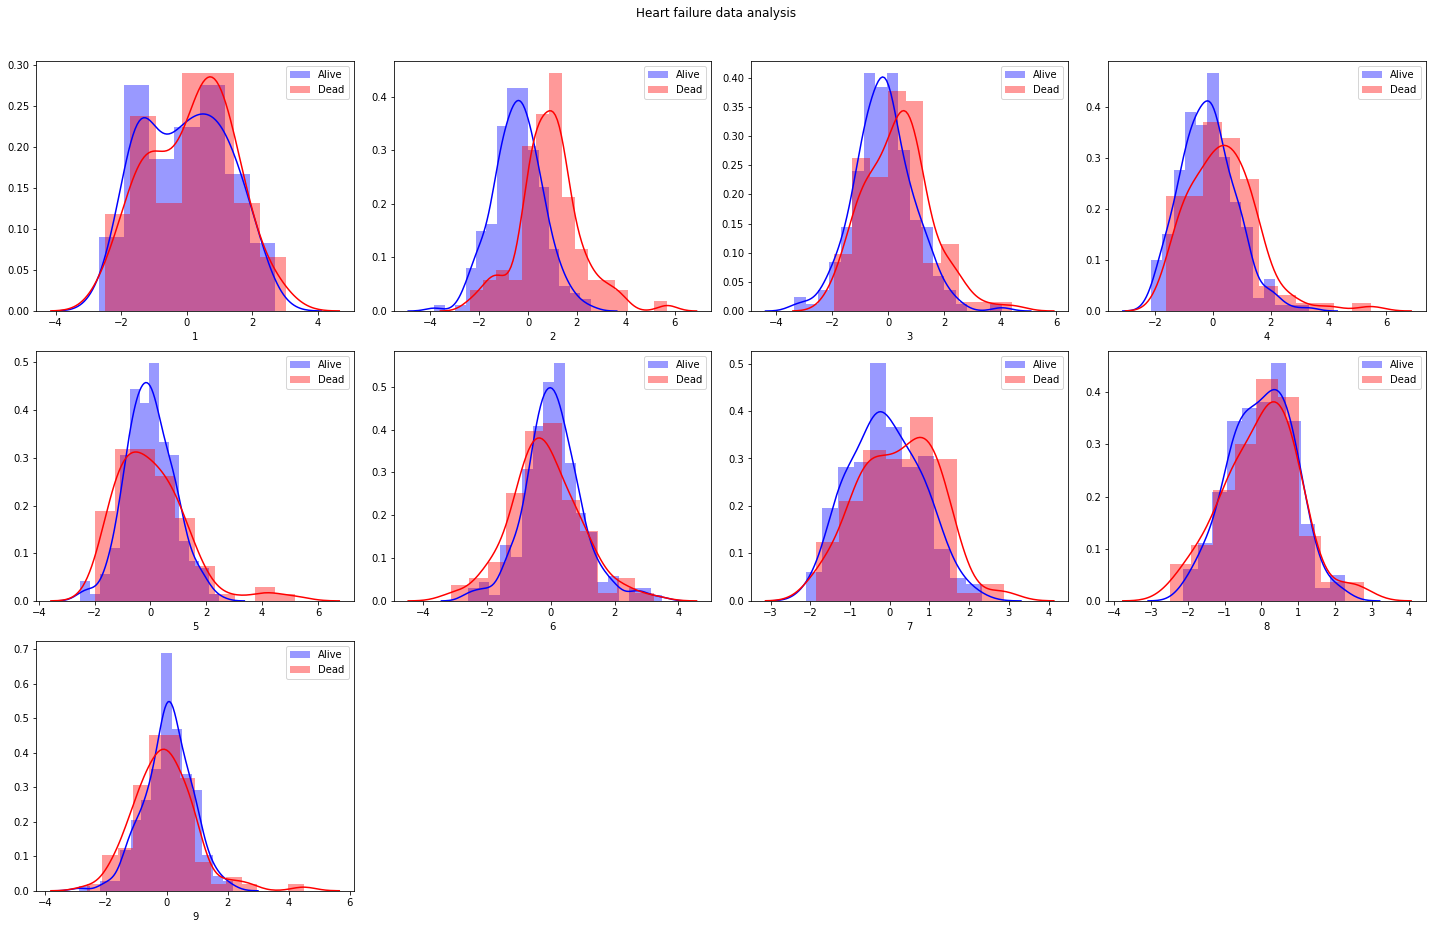

In [357]:
#Visualizing the selected features

fig = plt.figure(figsize = (20, 25))
j = 0
for i in principalDf.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(principalDf[i][df['DEATH_EVENT']==0], color='b', label = 'Alive')
    sns.distplot(principalDf[i][df['DEATH_EVENT']==1], color='r', label = 'Dead')
    plt.legend(loc='best')
fig.suptitle('Heart failure data analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

##Linear SVM with K-fold cross validation using principal components

##Preparing dataset with principal components
I first divide the dataset into training set (80%) and test set(20%)





In [358]:
x_train, x_test, y_train, y_test = train_test_split(principalComponents, y, test_size = 0.2)

x_train_Df = pd.DataFrame(data = x_train, columns = feature_names)
y_train_Df =pd.DataFrame(data=y_train, columns= ["DEATH_EVENT"])


trainDf = pd.concat([x_train_Df, y_train_Df], axis = 1)
#x_val, x_test, y_val, y_test = train_test_split(x, y, test_size = 0.5)




##Model training, validation and testing
Since data is a bit unbalanced and in order to reduce overfitting I decided to apply the k-fold cross validation tecnique on 10 folds and apply linear svm

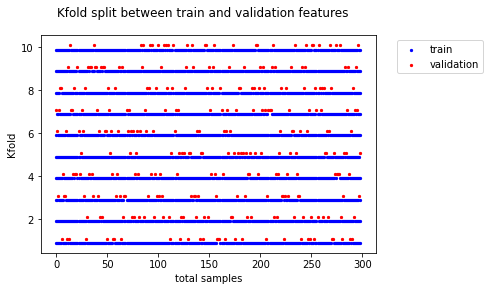

In [359]:
rn = range(0,299)
kf10 = KFold(n_splits=10, shuffle=True)

def kfoldize(kf, rn, shift=.1):
    train = pd.DataFrame()
    test = pd.DataFrame()
    i = 1
    for train_index, test_index in kf.split(rn):
        train_df = pd.DataFrame(np.take(rn, train_index), columns=["x"])
        train_df["val"] = i - shift
        train = train.append(train_df)

        test_df = pd.DataFrame(np.take(rn, test_index), columns=["x"])
        test_df["val"] = i + shift
        test = test.append(test_df)
        i += 1
    return train, test


train10, test10 = kfoldize(kf10,rn)


plt.scatter(x="x",y="val",c="b",label="train",s=5,data=train10)
plt.scatter(x="x",y="val",c="r",label="validation",s=5,data=test10)
plt.ylabel("Kfold")
plt.xlabel("total samples")
plt.suptitle("Kfold split between train and validation features")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [360]:

C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, feature_names]
      X_val = trainDf.iloc[test_index][feature_names]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']

      #linear svm application 
      
      

      #print("Analyzing fold {} ...".format(fold))

    
      #train the data on the training set
      clf=svm.SVC(kernel='linear', C=C)
      clf.fit(X_train,y_train) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each fold
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter in the fold
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVM=bestModel.predict(x_test)

acc_on_Test= accuracy_score(y_test,y_onTest_SVM)
print("Accuracy on test set={}".format(acc_on_Test))
  


analyzing C=0.001
total accuracy of the model after Cross Validation is: 66.97463768115941
analyzing C=0.01
total accuracy of the model after Cross Validation is: 71.59420289855072
analyzing C=0.1
total accuracy of the model after Cross Validation is: 79.09420289855072
analyzing C=1
total accuracy of the model after Cross Validation is: 78.29710144927535
analyzing C=10
total accuracy of the model after Cross Validation is: 78.69565217391305
analyzing C=100
total accuracy of the model after Cross Validation is: 80.34420289855072
analyzing C=1000
total accuracy of the model after Cross Validation is: 80.76086956521739


Best hyperparameter for the model is C=1000
Testing the model on the test set with the best hyperparameter
Accuracy on test set=0.85


#KFold Cross Validation

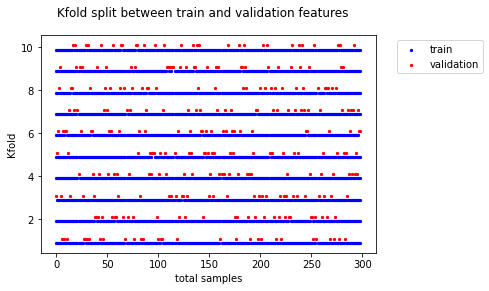

In [361]:
rn = range(0,299)
kf10 = KFold(n_splits=10, shuffle=True)

def kfoldize2(kf, rn, shift=.1):
    train = pd.DataFrame()
    test = pd.DataFrame()
    i = 1
    for train_index, test_index in kf.split(rn):
        train_df = pd.DataFrame(np.take(rn, train_index), columns=["x"])
        train_df["val"] = i - shift
        train = train.append(train_df)

        test_df = pd.DataFrame(np.take(rn, test_index), columns=["x"])
        test_df["val"] = i + shift
        test = test.append(test_df)
        i += 1
    return train, test


train10, test10 = kfoldize2(kf10,rn)


plt.scatter(x="x",y="val",c="b",label="train",s=5,data=train10)
plt.scatter(x="x",y="val",c="r",label="validation",s=5,data=test10)
plt.ylabel("Kfold")
plt.xlabel("total samples")
plt.suptitle("Kfold split between train and validation features")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

#Classifiers evaluation on original dataset

##Preparing dataset for classifiers
In all classifiers I will use k-fold cross validation in order to increase the performances and reduce overfitting
I divide the dataset into training set (80%) and test set (20%)

In [362]:
x_train_noPca, x_test_noPca, y_train_noPca, y_test_noPca = train_test_split(x, y, test_size = 0.2)

x_train_Df = pd.DataFrame(data = x_train_noPca, columns = features)
y_train_Df =pd.DataFrame(data=y_train_noPca, columns= ["DEATH_EVENT"])


trainDf = pd.concat([x_train_Df, y_train_Df], axis = 1)



##Linear SVM

In [363]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features]
      X_val = trainDf.iloc[test_index][features]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']

      #linear svm application 
      
      

      #print("Analyzing fold {} ...".format(fold))

    
      #train the data on the training set
      clf=svm.SVC(kernel='linear', C=C)
      clf.fit(X_train,y_train) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each fold
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter in the fold
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVM=bestModel.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVM)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVM, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVM, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVM, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))


analyzing C=0.001
total accuracy of the model after Cross Validation is: 70.34420289855073
analyzing C=0.01
total accuracy of the model after Cross Validation is: 75.21739130434783
analyzing C=0.1
total accuracy of the model after Cross Validation is: 83.71376811594203
analyzing C=1
total accuracy of the model after Cross Validation is: 82.84420289855072
analyzing C=10
total accuracy of the model after Cross Validation is: 84.07608695652173
analyzing C=100
total accuracy of the model after Cross Validation is: 83.71376811594203
analyzing C=1000
total accuracy of the model after Cross Validation is: 84.49275362318842


Best hyperparameter for the model is C=1000
Testing the model on the test set with the best hyperparameter
Accuracy on test set=0.75
Precision on test set=0.7579365079365079
Recall on test set=0.7228571428571429
F1 score on test set=0.7281787979462397


##RBF Kernel SVM
In order to try to increase the overall accuracy I try to apply the kernel trick.

As before I apply it using cross validation to reduce overfitting

In [364]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features]
      X_val = trainDf.iloc[test_index][features]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']

      #linear svm application 
      
      

      #print("Analyzing fold {} ...".format(fold))

    
      #train the data on the training set
      clf=svm.SVC(kernel='rbf', C=C)
      clf.fit(X_train,y_train) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each fold
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter in the fold
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVMRBF=bestModel.predict(x_test_noPca)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVMRBF, average='macro')

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVMRBF)
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))

analyzing C=0.001
total accuracy of the model after Cross Validation is: 70.27173913043477
analyzing C=0.01
total accuracy of the model after Cross Validation is: 70.32608695652173
analyzing C=0.1
total accuracy of the model after Cross Validation is: 70.28985507246377
analyzing C=1
total accuracy of the model after Cross Validation is: 81.57608695652175
analyzing C=10
total accuracy of the model after Cross Validation is: 81.55797101449276
analyzing C=100
total accuracy of the model after Cross Validation is: 75.74275362318839
analyzing C=1000
total accuracy of the model after Cross Validation is: 77.39130434782608


Best hyperparameter for the model is C=1
Testing the model on the test set with the best hyperparameter
Accuracy on test set=0.7
Precision on test set=0.711111111111111
Recall on test set=0.6628571428571428
F1 score on test set=0.6625


linear SVM model performs better

##Logistic regression 

In [365]:

fold = 0
acc_array_LR=[0,0,0,0,0,0,0,0,0,0]
for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features]
      X_val = trainDf.iloc[test_index][features]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']


      clf = LogisticRegression(random_state=0).fit(X_train,y_train)
      y_p_LR=clf.predict(X_val)
      acc_array_LR[fold]= accuracy_score(y_val,y_p_LR)
      fold=fold+1
#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",mean(acc_array_LR) * 100)      

y_onTest_LR=clf.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_LR)
precision_on_Test = precision_score(y_test_noPca, y_onTest_LR, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_LR, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_LR, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))


total accuracy of the model after Cross Validation is: 83.26086956521739
Accuracy on test set=0.7333333333333333
Precision on test set=0.7428180574555403
Recall on test set=0.7028571428571428
F1 score on test set=0.7069597069597069


##Random forest

In [366]:

fold = 0
acc_array_RF=[0,0,0,0,0,0,0,0,0,0]
for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features]
      X_val = trainDf.iloc[test_index][features]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']


      clf = RandomForestClassifier(max_depth=10, random_state=0).fit(X_train,y_train)
      y_p_RF=clf.predict(X_val)

      
      acc_array_RF[fold]= accuracy_score(y_val,y_p_RF)
      fold=fold+1
#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",mean(acc_array_RF) * 100)      

y_onTest_RF=clf.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_RF)
precision_on_Test = precision_score(y_test_noPca, y_onTest_RF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_RF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_RF, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))


total accuracy of the model after Cross Validation is: 84.49275362318842
Accuracy on test set=0.8
Precision on test set=0.7967097532314924
Recall on test set=0.7885714285714285
F1 score on test set=0.7916666666666666


#Classifiers with smote oversampling tecnique

##Define some useful function

In [367]:
def nearest_neighbour(X, x):
    euclidean = np.ones(X.shape[0]-1)
    
    additive = [None]*(1*X.shape[1])
    additive = np.array(additive).reshape(1, X.shape[1])
    k = 0
    for j in range(0,X.shape[0]):
        if np.array_equal(X[j], x) == False:
            euclidean[k] = sqrt(sum((X[j]-x)**2))
            k = k + 1
    euclidean = np.sort(euclidean)
    weight = rand.random()
    while(weight == 0):
        weight = rand.random()
    additive = np.multiply(euclidean[:1],weight)
    return additive
    
def SMOTE_100(X):
    new = [None]*(X.shape[0]*X.shape[1])
    new = np.array(new).reshape(X.shape[0],X.shape[1])
    k = 0
    for i in range(0,X.shape[0]):
        additive = nearest_neighbour(X, X[i])
        for j in range(0,1):
            new[k] = X[i] + additive[j]
            k = k + 1
    return new 

##Linear SVM

In [368]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features].values
      X_val = trainDf.iloc[test_index][features].values
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT'].values
      y_val = trainDf.loc[test_index]['DEATH_EVENT'].values

      #apply smote
      unique, counts = np.unique(y_train, return_counts=True)
      minority_shape = dict(zip(unique, counts))[1]
      x1 = np.ones((minority_shape, X_train.shape[1]))
      k=0
      for i in range(0,X_train.shape[0]):
          
          if y_train[i] == 1:
              
              x1[k] = X_train[i]
              k = k + 1
      sampled_instances = SMOTE_100(x1)
      X_f = np.concatenate((X_train,sampled_instances), axis = 0)
      y_sampled_instances = np.ones(minority_shape)
      y_f = np.concatenate((y_train,y_sampled_instances), axis=0)
      #train the data on the training set
      clf=svm.SVC(kernel='linear', C=C)
      clf.fit(X_f,y_f) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each fold
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter in the fold
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVM=bestModel.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVM)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVM, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVM, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVM, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))


analyzing C=0.001
total accuracy of the model after Cross Validation is: 71.1231884057971
analyzing C=0.01
total accuracy of the model after Cross Validation is: 76.95652173913045
analyzing C=0.1
total accuracy of the model after Cross Validation is: 81.21376811594203
analyzing C=1
total accuracy of the model after Cross Validation is: 80.72463768115942
analyzing C=10
total accuracy of the model after Cross Validation is: 79.94565217391305
analyzing C=100
total accuracy of the model after Cross Validation is: 79.47463768115941
analyzing C=1000
total accuracy of the model after Cross Validation is: 82.84420289855072


Best hyperparameter for the model is C=1000
Testing the model on the test set with the best hyperparameter
Accuracy on test set with smote=0.6833333333333333
Precision on test set with smote=0.675
Recall on test set with smote=0.66
F1 score on test set with smote=0.6622222222222223


##RBF Kernel SVM

In [369]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features].values
      X_val = trainDf.iloc[test_index][features].values
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT'].values
      y_val = trainDf.loc[test_index]['DEATH_EVENT'].values

      #apply smote
      unique, counts = np.unique(y_train, return_counts=True)
      minority_shape = dict(zip(unique, counts))[1]
      x1 = np.ones((minority_shape, X_train.shape[1]))
      k=0
      for i in range(0,X_train.shape[0]):
          
          if y_train[i] == 1:
              
              x1[k] = X_train[i]
              k = k + 1
      sampled_instances = SMOTE_100(x1)
      X_f = np.concatenate((X_train,sampled_instances), axis = 0)
      y_sampled_instances = np.ones(minority_shape)
      y_f = np.concatenate((y_train,y_sampled_instances), axis=0)
    

    
      #train the data on the training set
      clf=svm.SVC(kernel='rbf', C=C)
      clf.fit(X_f,y_f) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each fold
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter in the fold
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVMRBF=bestModel.predict(x_test_noPca)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVMRBF, average='macro')

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVMRBF)
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))

analyzing C=0.001
total accuracy of the model after Cross Validation is: 70.34420289855072
analyzing C=0.01
total accuracy of the model after Cross Validation is: 70.27173913043477
analyzing C=0.1
total accuracy of the model after Cross Validation is: 77.0108695652174
analyzing C=1
total accuracy of the model after Cross Validation is: 81.99275362318842
analyzing C=10
total accuracy of the model after Cross Validation is: 79.92753623188406
analyzing C=100
total accuracy of the model after Cross Validation is: 76.55797101449275
analyzing C=1000
total accuracy of the model after Cross Validation is: 79.1304347826087


Best hyperparameter for the model is C=1
Testing the model on the test set with the best hyperparameter
Accuracy on test set with smote=0.7
Precision on test set with smote=0.6957637997432606
Recall on test set with smote=0.6742857142857144
F1 score on test set with smote=0.6770334928229665


##Logistic regression

In [370]:
fold = 0
acc_array_LR=[0,0,0,0,0,0,0,0,0,0]
for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features].values
      X_val = trainDf.iloc[test_index][features].values
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT'].values
      y_val = trainDf.loc[test_index]['DEATH_EVENT'].values

      #apply smote
      unique, counts = np.unique(y_train, return_counts=True)
      minority_shape = dict(zip(unique, counts))[1]
      x1 = np.ones((minority_shape, X_train.shape[1]))
      k=0
      for i in range(0,X_train.shape[0]):
          
          if y_train[i] == 1:
              
              x1[k] = X_train[i]
              k = k + 1
      sampled_instances = SMOTE_100(x1)
      X_f = np.concatenate((X_train,sampled_instances), axis = 0)
      y_sampled_instances = np.ones(minority_shape)
      y_f = np.concatenate((y_train,y_sampled_instances), axis=0)




      clf = LogisticRegression(random_state=0).fit(X_f,y_f)
      y_p_LR=clf.predict(X_val)
      acc_array_LR[fold]= accuracy_score(y_val,y_p_LR)
      fold=fold+1
#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",mean(acc_array_LR) * 100)      

y_onTest_LR=clf.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_LR)
precision_on_Test = precision_score(y_test_noPca, y_onTest_LR, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_LR, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_LR, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set= with smote{}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))

total accuracy of the model after Cross Validation is: 81.12318840579708
Accuracy on test set with smote=0.7
Precision on test set= with smote0.6957637997432606
Recall on test set with smote=0.6742857142857144
F1 score on test set with smote=0.6770334928229665


##Random forest

In [371]:
fold = 0
acc_array_RF=[0,0,0,0,0,0,0,0,0,0]
for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features].values
      X_val = trainDf.iloc[test_index][features].values
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT'].values
      y_val = trainDf.loc[test_index]['DEATH_EVENT'].values


      #apply smote
      unique, counts = np.unique(y_train, return_counts=True)
      minority_shape = dict(zip(unique, counts))[1]
      x1 = np.ones((minority_shape, X_train.shape[1]))
      k=0
      for i in range(0,X_train.shape[0]):
          
          if y_train[i] == 1:
              
              x1[k] = X_train[i]
              k = k + 1
      sampled_instances = SMOTE_100(x1)
      X_f = np.concatenate((X_train,sampled_instances), axis = 0)
      y_sampled_instances = np.ones(minority_shape)
      y_f = np.concatenate((y_train,y_sampled_instances), axis=0)


      clf = RandomForestClassifier(max_depth=10, random_state=0).fit(X_f,y_f)
      y_p_RF=clf.predict(X_val)

      
      acc_array_RF[fold]= accuracy_score(y_val,y_p_RF)
      fold=fold+1
#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",mean(acc_array_RF) * 100)      

y_onTest_RF=clf.predict(x_test_noPca)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_RF)
precision_on_Test = precision_score(y_test_noPca, y_onTest_RF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_RF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_RF, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))

total accuracy of the model after Cross Validation is: 85.3623188405797
Accuracy on test set with smote=0.8166666666666667
Precision on test set with smote=0.8169856459330144
Recall on test set with smote=0.8028571428571428
F1 score on test set with smote=0.8076362576508307
